# 0. LLM-assisted Knowledge Graph construction

The goal of this notebook is to illustrate some of the techniques we have seen in the first part of this tutorial.

**How to go from unstructured (a document text, like a PubMed article) to structured data (a Knowledge Graph) ?**

Basically, we have seen that there is 2 main strategies:
- **Supervised** (pre-LLM era): where we use transformer models (typically some PubMedBERT, BioBERT, etc.) to perform the key steps on Named Entity Recognition (NER) and Relation Extraction (RE)

- **Unsupervised (or weakly supervised)**: where we leverage LLMs in few-shots settings to perform these tasks.

Each strategy comes with its *pro* and *cons*.

Classic approaches benefit from the fine-tuning on labeled data and show good performances with a reasonable inference speed. These models are also way lighter than the LLM counterparts where a BERT model is typically ~120M parameters where LLM will start around 8B parameters.

On the other side, LLM benefit from their large pre-training and show zero/few-shot learning abilties.

Zero-shot learning refers to the model's ability to perform tasks without any explicit examples or prior task-specific training data. The model can handle a task based on its pre-existing knowledge learned from a large corpus during training, even if it has never seen an example for that specific task.

Few-shot learning refers to the model's ability to perform tasks with only a small number of examples (usually fewer than 10). Unlike zero-shot learning, where no examples are provided, few-shot learning involves giving the model a few examples or demonstrations of the task at hand.

This can be very convenient when no, or just few labeled data are available. In the biomedical domain, we often need expert to annotate data, which can be costly and time consuming.



## Settings

In [ ]:
# First, we need to install dspy
!pip install backoff
!pip install dspy
!pip install transformers
!pip install peft
!pip install sacremoses

In [ ]:
# import
import json
import random
import requests
import hashlib
import backoff
import logging
from tqdm import tqdm
from time import sleep
from typing import List, Tuple
from collections import defaultdict
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from langchain_core.documents.base import Document
from IPython.display import display, HTML, Markdown


# 1. PubTator: An end-to-end pipeline with PubTator


[PubTator 3.0](https://www.ncbi.nlm.nih.gov/research/pubtator3) is a biomedical text mining tool developed by the National Center for Biotechnology Information (NCBI) to assist researchers in automatically annotating and extracting key biological concepts from scientific literature. The tool is specifically designed to help in annotating articles with information on genes, diseases, chemicals, mutations, and species.

PubTator is a good entry point for using transformer-based models for NER/RE.

## Named Entity Recognition with PubTator

Behind the scene Pubtator use a transformer based encoder trained on the available BioNER datasets (BC5CDR, BioRED, etc.) (see [1] for more details)

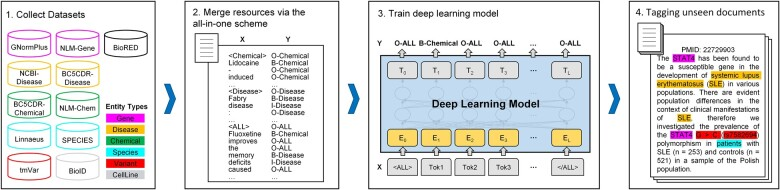


## Relation Extraction with PubTator

Similarly, a RE module has been trained on top of an encoder to classify the relations between pairs of entities (see [2] for more details).


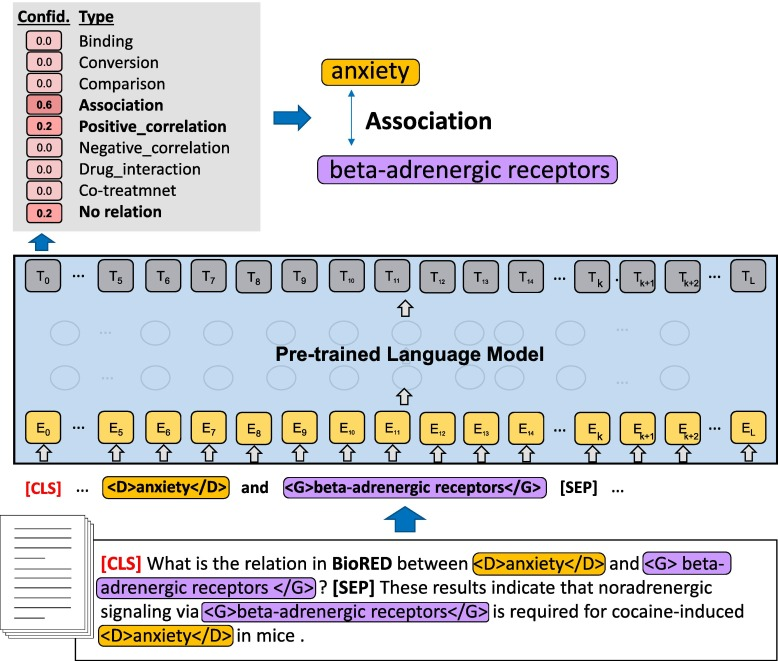

## Entity Linking with PubTator

PubTator also directly integrates an entity Linking (EL) module, specialised for biomedical entities. Diseases and Cell-lines are mapped with TaggerOne [3], while genes are mapped to NCBI gene ids with GNorm2 [4].

Based on these models, PubTator provide an automatically and API-available NER and RE from PubMed abstracts and full-text PMC.

It currently holds more than one billion annotations of entities and relationships from around 36 million PubMed abstracts and 6 million full-text articles in the PMC open-access subset, with weekly updates contributing to its continuous growth.

**Warnings**: While Pubtator is an *"ALL-IN-ONE"* strategy, of course, there exist models that will individually perform better separate tasks.


[1] Luo L et al. AIONER: all-in-one scheme-based biomedical named entity recognition using deep learning. Bioinformatics. 2023 (doi: 10.1093/bioinformatics/btad310)

[2] Po-Ting Lai et al. BioREx: Improving biomedical relation extraction by leveraging heterogeneous datasets. Journal of Biomedical Informatics 2023 (doi: doi.org/10.1016/j.jbi.2023.104487)

[3] Leaman R, Lu Z. TaggerOne: joint named entity recognition and normalization with semi-Markov Models. Bioinformatics. 2016 (doi: 10.1093/bioinformatics/btw343)

[4] Wei CH et al. GNorm2: an improved gene name recognition and normalization system. Bioinformatics. 2023 (doi: 10.1093/bioinformatics/btad599)

## Playing with PubTator ...

### PubTator Client Utility Class

In [ ]:
class PubTatorClient:
    def __init__(self, base_url: str, max_retries: int = 3):
        self.session = requests.Session()
        self.base_url = base_url
        # Configure retry strategy
        retry_strategy = Retry(
            total=max_retries,
            backoff_factor=1,
            status_forcelist=[429, 500, 502, 503, 504],
        )

        adapter = HTTPAdapter(max_retries=retry_strategy)
        self.session.mount("http://", adapter)
        self.session.mount("https://", adapter)
        self.logger = logging.getLogger(__name__)

    @backoff.on_exception(
        backoff.expo, requests.exceptions.RequestException, max_tries=3
    )
    def _fetch_publications(self, pmids: List[str]) -> dict:
        params = {"pmids": ",".join(pmids)}

        response = self.session.get(self.base_url, params=params, timeout=300)
        response.raise_for_status()
        return response.json()

    def _parse(self, response: dict):
        doc_text = "\n".join([passage["text"] for passage in response["passages"]])
        pmid = response["id"]
        doc = {"pmid": pmid, "text": doc_text}
        biomedical_entities = []
        biomedical_relations = []
        # To save the accession number and map back the entities in the relations.
        accession_dict = {}

        for passage in response["passages"]:
            annotations = passage["annotations"]
            for annotation in annotations:
                # For simplicity, we are only going to keep the 'valid' annotations.
                if not annotation['infons'].get('valid', False):
                  continue
                span = annotation["text"]
                name = annotation["infons"]["name"]
                annot_type = annotation["infons"]["type"]
                identifier = annotation["infons"]["identifier"]
                accession = annotation["infons"]["accession"]
                accession_dict[accession] = {"type": annot_type, "identifier": identifier}

                # Sometimes, there can be an entry for identifier, but it is actaully not determined and refer the '-'.
                if identifier == "-":
                    identifier = hashlib.sha256(span.encode("utf-8")).hexdigest()
                biomedical_entities.append({
                    "label": annot_type,
                    "span": span,
                    "name": name,
                    "id": identifier,
                    "pmid": pmid
                })
        for relation_info in response['relations_display']:

          rel_type, s_accession_id, o_accession_id = relation_info['name'].split('|')
          source = accession_dict.get(s_accession_id, {})
          target = accession_dict.get(o_accession_id, {})
          if not source or not target:
            continue
          source_id = source['identifier']
          target_id = target['identifier']
          source_label = source['type']
          target_label = target['type']
          biomedical_relations.append({
                "source_id": source_id,
                "source_label": source_label,
                "target_id": target_id,
                "target_label": target_label,
                "relationship": rel_type,
                "pmid": pmid
              })

        return biomedical_entities, biomedical_relations, doc

    def _merge(self, biomedical_entities: List[dict], biomedical_relations: List[dict]) -> List[Document]:
        all_merged_biomedical_entities = {}
        all_merged_biomedical_relations = {}
        for biomedical_entity in biomedical_entities:
          if biomedical_entity['id'] not in all_merged_biomedical_entities:
            all_merged_biomedical_entities[biomedical_entity['id']] = biomedical_entity
            all_merged_biomedical_entities[biomedical_entity['id']]['alt_names'] = [biomedical_entity['span']]
            all_merged_biomedical_entities[biomedical_entity['id']]['pmids'] = [biomedical_entity['pmid']]
          else:
            _span = biomedical_entity['span']
            _pmid = biomedical_entity['pmid']
            if _span not in all_merged_biomedical_entities[biomedical_entity['id']]['alt_names']:
              all_merged_biomedical_entities[biomedical_entity['id']]['alt_names'].append(_span)

            if _pmid not in all_merged_biomedical_entities[biomedical_entity['id']]['pmids']:
              all_merged_biomedical_entities[biomedical_entity['id']]['pmids'].append(_pmid)

        for biomedical_relation in biomedical_relations:
          source_id = biomedical_relation['source_id']
          target_id = biomedical_relation['target_id']
          source_label = biomedical_relation['source_label']
          target_label = biomedical_relation['target_label']
          relationship = biomedical_relation['relationship']
          _id = f"{source_label}_{source_id}_{target_label}_{target_id}_{relationship}"
          if _id not in all_merged_biomedical_relations:
              all_merged_biomedical_relations[_id] = {
                  "source_id": source_id,
                  "source_label": source_label,
                  "target_id": target_id,
                  "target_label": target_label,
                  "relationship": relationship,
                  "pmids": [biomedical_relation['pmid']]
                }
          else:
              _pmid = biomedical_relation['pmid']
              if _pmid not in all_merged_biomedical_relations[_id]['pmids']:
                all_merged_biomedical_relations[_id]['pmids'].append(_pmid)

        merged_biomedical_entities = list(all_merged_biomedical_entities.values())
        merged_biomedical_relations = list(all_merged_biomedical_relations.values())
        return merged_biomedical_entities, merged_biomedical_relations

    def request_and_parse_pubtator(self, pmids: List[str], pubtator_chunk_size=50):
        all_responses = []

        # STEP 1: Fetching the PubTator Informations
        self.logger.info("Fetching PubTator data...")
        for i in tqdm(
            range(0, len(pmids), pubtator_chunk_size),
            desc="Fetching PubTator data",
        ):
            chunk = pmids[i : i + pubtator_chunk_size]
            try:
                response = self._fetch_publications(chunk)
                all_responses.append(response)
            except requests.exceptions.RequestException as e:
                self.logger.error(
                    f"Failed to fetch data from PubTator API for chunk {chunk}: {e}"
                )
            sleep(0.5)

        fetched_ner_re = [doc for pubtator_response in all_responses
            for doc in pubtator_response["PubTator3"]
        ]
        self.logger.info(f"Fetched {len(fetched_ner_re)} PubTator data.")

        # STEP 2: Parsing the PubTator Identified Biomedical Named Entities and Relations
        self.logger.info("Parsing PubTator data...")
        biomedical_ner = []
        biomedical_re = []
        documents_texts = []
        for item in tqdm(fetched_ner_re, desc="Parsing PubTator data"):
            _biomedical_ner, _biomedical_re, doc = self._parse(item)
            biomedical_ner += _biomedical_ner
            biomedical_re += _biomedical_re
            documents_texts.append(doc)

        # STEP 3: Merge Biomedical Entities and Relations
        merged_biomedical_entities, merged_biomedical_relations = self._merge(biomedical_ner, biomedical_re)
        return merged_biomedical_entities, merged_biomedical_relations, documents_texts


color_map = {
    'Gene': '#b4a7d6ff',
    'Chemical': '#93c47dff',
    'Disease': '#f9cb9cff',
    'Variant': '#e06666ff',
    'Species': '#a4c2f4ff'
}

def display_entities(entities):

    # Helper to get link from label and id
    def get_id_link(label, id_value):
        if label == 'Gene':
            return f'<a href="https://www.ncbi.nlm.nih.gov/gene/{id_value}" target="_blank">{id_value}</a>'
        elif label in ['Disease', 'Chemical']:
            id_val = id_value.split(':')[1]
            return f'<a href="https://meshb.nlm.nih.gov/record/ui?ui={id_val}" target="_blank">{id_value}</a>'
        elif label == 'Species':
            return f'<a href="https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id={id_value}" target="_blank">{id_value}</a>'
        else:
            return id_value

    # Build HTML
    html = '<div style="font-family:monospace;">'
    for entry in merged_biomedical_entities:
        color = color_map.get(entry['label'], '#dddddd')
        id_link = get_id_link(entry['label'], entry['id'])
        html += f"""
        <div style="margin:8px 0;padding:10px;border-radius:8px;background-color:{color};">
            <strong>{entry['label']}</strong><br>
            <span><strong>Span:</strong> {entry['span']}</span><br>
            <span><strong>Name:</strong> {entry['name']}</span><br>
            <span><strong>ID:</strong> {id_link}</span><br>
            <span><strong>PMID:</strong> {entry['pmid']}</span><br>
            <span><strong>Alt Names:</strong> {', '.join(entry['alt_names'])}</span>
        </div>
        """

    html += '</div>'

    # Display
    display(HTML(html))


def display_relations(relations):

    # Helper to make a colored label block
    def make_node(label, id_value):
        color = color_map.get(label, '#dddddd')
        if label == "Variant":
            id_value = id_value[: 10] + " ..."
        return f'''
        <span style="background-color:{color};padding:4px 8px;border-radius:6px;">
            <strong>{label}</strong> / {id_value}
        </span>
        '''

    # Build HTML
    html = '<div style="font-family:monospace;">'

    for r in merged_biomedical_relations:
        source = make_node(r['source_label'], r['source_id'])
        target = make_node(r['target_label'], r['target_id'])
        pmid = ', '.join(r['pmids'])
        rel = r['relationship']
        html += f'''
        <div style="margin:8px 0;padding:6px;">
            {source}
            <span style="margin: 0 10px;">-- <em>{rel}</em> (ref: {pmid}) --> </span>
            {target}
        </div>
        '''

    html += '</div>'

    # Display in notebook
    display(HTML(html))

### Getting NER and RE from PubTator

Let's look at the article [*Development of a high-throughput TR-FRET screening assay for a fast-cycling KRAS mutant.*](https://pubmed.ncbi.nlm.nih.gov/36563789)

[Here](https://www.ncbi.nlm.nih.gov/research/pubtator3/publication/36563789?text=36563789) is a link to the PubTator entry.

Using the parse we have provided above (**PubTatorClient**), we are going to extract and visualized the entities and their relations.

In [ ]:
pubtator = PubTatorClient(base_url="https://www.ncbi.nlm.nih.gov/research/pubtator3-api/publications/export/biocjson")

In [ ]:
merged_biomedical_entities, merged_biomedical_relations, documents_texts = pubtator.request_and_parse_pubtator(["36563789"])

Here, entities will represent our nodes (subject or objects) in the Knowledge Graph.

They have:
- a type (eg. Gene)
- a unique identifier from the EL part to desambiguate and align several mentions of the same entities.
- Name: the official name according to the used vocabulary (eg. NCBI Gene for genes)
- Alternative names: a potential list of all the names coming from the extracted spans.
- PMID: a list of publication to track where we extracted them.

In [ ]:
display_entities(merged_biomedical_entities)

Here we have the relations extracted that will represent the edges on the KG.
They connect node entities (based on their unique identifier) and their relation is also labeled (eg. associate / treat / inhibit), etc.

In [ ]:
display_relations(merged_biomedical_relations)

Very fast right !

Through this process, we have successfully extracted some core knowledge from the abstract and convert it as a list of triples (subject, predicate, objects)

For instance: (Lumakras, treat, NSCLC)

Thanks to the NER/EL we can also have access to the external knowledge from MeSH to understand the taxonomic position of these diseases.

There is of course few remarks we can make:
-  Some compounds (like *UNC10104889* or *MRTX1133*) cannot properly be desambiguate to identifiers without more context as provided in the full-text.

- The relations between the drugs (like sotorasib) and NSCLC are actually more complex than a simple "treat", as sotorasib is specifically a KRAS G12C inhibitor, meaning it binds to the mutated KRAS G12C protein, locks it in an inactive state, and blocks its ability to promote cancer cell growth.

- Should KRAS G12C NSCLC be considered as a sub-type of NSCLC and therefore also as a disease ? Have a look at some **Nested NER**.

- Are all relations correct ?

  - `(MRTX1133)-[treat]-> (neoplasm)` ?
  - `(G12D)-[associate]->(colorectal cancer)` ?
  - `(MRTX1133)-[inhibit]->(G12C)` ?


### let's schematise the Graph we have


gp1.svg

gp2.svg

## Large Language Model: NER and RE

What if my documents are not in PubMed for instance ? Or if I want to extract other types of relations / entities ?

Question: What can we obtain by simply prompting our LLM (for instance GPT-4o-mini) to perform the same task ?

There is no "official" estimates of the size of GPT-4o-mini, but it is definitely way larger than the BioBERT base models used by PubTator.

Before diving in the prompting of the model, we are going to briefly introduce the (amazing) library we are going to use for this: dspy

### What is dspy?

[dspy](https://dspy.ai/) is a framework for programming with large language models (LLMs).

Instead of thinking of LLMs as black boxes that you “prompt” with clever instructions, dspy treats them as programmable components. You don’t just write one-off prompts; you define modules that behave like functions:

- Inputs (structured, typed arguments)
- Outputs (structured, validated objects)
- Internal reasoning (delegated to the LLM)

This makes LLM applications deterministic, testable, and composable — closer to software engineering than trial-and-error prompting.


#### "Programming, not prompting"

Normally with LLMs you would write something like:

“Extract biomedical entities and their relations from PubMed title and abstract text.”

and hope the model follows instructions.

With dspy, you declare a task:

```python
class BiomedicalNERRE(dspy.Module):
    def forward(self, text: str) -> List[Relation]:
        ...
```

The LLM is then constrained to produce output that matches this schema (`List[Relation]`).

This shifts the burden from "write the perfect prompt" → "define the right program structure".

A core idea in dspy is that LLMs should return structured data, not free-form text.

Example: instead of asking for a JSON blob and hoping it parses, you can specify:

```python
class EntityType(str, Enum):
    """Entity types for biomedical NER"""
    GENE = "Gene"
    DISEASE = "Disease"
    CHEMICAL = "Chemical"
    VARIANT = "Variant"
    SPECIES = "Species"
    CELL_LINE = "Cell Line"

class RelationType(str, Enum):
    """Relation types for biomedical RE"""
    ASSOCIATE = "ASSOCIATE"
    CAUSE = "CAUSE"
    COMPARE = "COMPARE"
    COTREAT = "COTREAT"
    DRUG_INTERACT = "DRUG_INTERACT"
    INHIBIT = "INHIBIT"
    INTERACT = "INTERACT"
    NEGATIVE_CORRELATE = "NEGATIVE_CORRELATE"
    POSITIVE_CORRELATE = "POSITIVE_CORRELATE"
    PREVENT = "PREVENT"
    STIMULATE = "STIMULATE"
    TREAT = "TREAT"

class Relation(BaseModel):
    """Represents a relation between two entities"""
    entity1_span: str = Field(description="Text span of the first entity")
    entity1_type: EntityType = Field(
        description="Type of the first entity"
    )
    entity2_span: str = Field(description="Text span of the second entity")
    entity2_type: EntityType = Field(
        description="Type of the second entity"
    )
    relation_type: RelationType = Field(description="Type of relation between entities")

```

### Few-shots seetings

As the LLM has not been specifically trained before to solve this task, we are going to provide him with some demonstrations of the task.

[Here](https://pubmed.ncbi.nlm.nih.gov/31172372) is the abstract use in the example.


For instance:

```json
{
        "pubmed_text": "Bimekizumab: The First Dual Inhibitor of Interleukin (IL)-17A and IL-17F for the Treatment of Psoriatic Disease and Ankylosing Spondylitis. Psoriasis is a chronic inflammatory skin disease with significant psychological and physical impact. Over the last few decades, several highly effective target therapies have been developed, leading to a major paradigm shift in the way psoriatic disease is managed. Despite this, a proportion of patients still do not respond or lose response over time. Bispecific antibodies target two different cytokines simultaneously, potentially offering a better disease control. Interleukin (IL)-17A and IL-17F share structural homology and have similar biologic function. IL-17A is classically considered to be the most biologically active, but recent studies have shown that IL-17F is also increased in psoriatic skin and synovial cell in psoriatic arthritis, supporting the rationale for targeting both IL-17A and IL-17F in psoriatic disease. Bimekizumab is the first-in-class monoclonal antibody designed to simultaneously target IL-17A and IL-17F. Bimekizumab is currently in clinical development for psoriasis, psoriatic arthritis, and ankylosing spondylitis, with promising results. In early clinical trials, bimekizumab demonstrated a rapid onset of action, good safety profile, and high tolerability by treated study participants. Long-term results and head-to-head trials comparing bimekizumab with other agents will be crucial to define the role of bimekizumab in the treatment of psoriatic disease.",
        "relations": [
            Relation(
                entity1_span="IL-17A", entity1_type="Gene",
                entity2_span="Psoriatic Disease", entity2_type="Disease",
                relation_type="ASSOCIATE"
            ),
            Relation(
                entity1_span="IL-17F", entity1_type="Gene",
                entity2_span="Psoriatic Disease", entity2_type="Disease",
                relation_type="ASSOCIATE"
            ),
            Relation(
                entity1_span="IL-17A", entity1_type="Gene",
                entity2_span="Ankylosing Spondylitis", entity2_type="Disease",
                relation_type="ASSOCIATE"
            ),
            Relation(
                entity1_span="IL-17F", entity1_type="Gene",
                entity2_span="Ankylosing Spondylitis", entity2_type="Disease",
                relation_type="ASSOCIATE"
            ),
            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="IL-17A", entity2_type="Gene",
                relation_type="NEGATIVE_CORRELATE"
            ),
            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="IL-17F", entity2_type="Gene",
                relation_type="NEGATIVE_CORRELATE"
            ),
            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="psoriasis", entity2_type="Disease",
                relation_type="TREAT"
            ),
            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="psoriatic arthritis", entity2_type="Disease",
                relation_type="TREAT"
            ),

            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="ankylosing spondylitis", entity2_type="Disease",
                relation_type="TREAT"
            )
        ]
    }
```

### Calling LLM with dspy and structured JSON outputs

Here, don't forget to create a `.env` file with your openAI API_KEY like this:
```env
OPENAI_API_KEY="sk-proj-..."
```

If you don't have, no worry, we also gonna show an example with open models running with ollama on this notebook.


In [ ]:
import os
import json
import dspy
from enum import Enum
from dotenv import load_dotenv, find_dotenv
from pydantic import BaseModel, Field
from typing import List, Optional, Literal

# load .env vars
_ = load_dotenv(find_dotenv())

In [ ]:
# Define entity and relation types using Pydantic models
class EntityType(str, Enum):
    """Entity types for biomedical NER"""
    GENE = "Gene"
    DISEASE = "Disease"
    CHEMICAL = "Chemical"
    VARIANT = "Variant"
    SPECIES = "Species"
    CELL_LINE = "Cell Line"
    # EXPERIMENTAL_METHOD = "Experimental Method"

class RelationType(str, Enum):
    """Relation types for biomedical RE"""
    ASSOCIATE = "ASSOCIATE"
    CAUSE = "CAUSE"
    COMPARE = "COMPARE"
    COTREAT = "COTREAT"
    DRUG_INTERACT = "DRUG_INTERACT"
    INHIBIT = "INHIBIT"
    INTERACT = "INTERACT"
    NEGATIVE_CORRELATE = "NEGATIVE_CORRELATE"
    POSITIVE_CORRELATE = "POSITIVE_CORRELATE"
    PREVENT = "PREVENT"
    STIMULATE = "STIMULATE"
    TREAT = "TREAT"
    # MEASURE = "MEASURE"

class Relation(BaseModel):
    """Represents a relation between two entities"""
    entity1_span: str = Field(description="Text span of the first entity")
    entity1_type: EntityType = Field(
        description="Type of the first entity"
    )
    entity2_span: str = Field(description="Text span of the second entity")
    entity2_type: EntityType = Field(
        description="Type of the second entity"
    )
    relation_type: RelationType = Field(description="Type of relation between entities")


# DSPy signature for biomedical extraction from PubMed abstracts

# - Experimental methods: NMR, RNA-Seq, HPLC, etc.
# - MEASURE: When an Experimental method is used to measure/identify some bioentities.
class BiomedicalExtraction(dspy.Signature):
    """
    Extract biomedical entities and their relations from PubMed title and abstract text.
    Focus on scientifically relevant entities and relationships commonly found in biomedical literature.

    Entity Types with PubMed Context:
    - Gene: Protein-coding genes, gene symbols (e.g., BRCA1, TP53), gene families
    - Disease: Diseases, disorders, syndromes, pathological conditions from MeSH
    - Chemical: Drugs, compounds, metabolites, therapeutic agents from MeSH
    - Variant: SNPs (rs numbers), mutations (p.Val600Glu), copy number variants
    - Species: Organisms, model systems (Homo sapiens, Mus musculus, etc.)
    - Cell Line: Immortalized cell lines, primary cells (HeLa, MCF-7, etc.)

    Relation Types for PubMed Literature:
    - ASSOCIATE: General biological association or correlation
    - CAUSE: Causal relationships, pathogenesis, disease etiology
    - COMPARE: Comparative studies, drug comparisons, treatment efficacy
    - COTREAT: Combination therapies, drug combinations
    - DRUG_INTERACT: Drug-drug interactions, pharmacological interactions
    - INHIBIT: Inhibition, suppression, downregulation
    - INTERACT: Physical/molecular interactions, binding, complexes
    - NEGATIVE_CORRELATE: Inverse correlation, negative association
    - POSITIVE_CORRELATE: Positive correlation, co-expression, co-regulation
    - PREVENT: Prevention, protective effects, risk reduction
    - STIMULATE: Activation, upregulation, enhancement
    - TREAT: Therapeutic relationships, treatment efficacy

    Instructions:
    - Extract entities as they appear in the text (preserve original naming)
    - Focus on scientifically meaningful relationships
    - Consider both title and abstract content
    - Prioritize well-established biomedical relationships
    - Handle abbreviations and full names appropriately
    - Do NOT integrate novel Relation Types
    """

    pubmed_text: str = dspy.InputField(desc="PubMed title and abstract text")
    relations: List[Relation] = dspy.OutputField(desc="Extracted biomedical relations")

In [ ]:
# DSPy signature for biomedical extraction from PubMed abstracts
class NPBiomedicalExtraction(dspy.Signature):
    """
    The task is to extract natural-products relationships between organisms and chemicals from the input text.
    Return all the extracted relations where the text report evidence that an organism produces a chemical, in the form of 'organism produces chemical.'
    You will be given some examples of the tasks.
    """

    pubmed_text: str = dspy.InputField(desc="PubMed title and abstract text")
    relations: List[Tuple[str, str]] = dspy.OutputField(desc="The extraction pair (organism, chemical)")

NP_PUBMED_EXAMPLES = [
    {
    "pubmed_text": "Dihydroagarofuran alkaloid and triterpenes from Maytenus heterophylla and Maytenus arbutifolia. The antimicrobially active EtOH extracts of Maytenus heterophylla yielded a new dihydroagarofuran alkaloid,1beta-acetoxy-9alpha-benzoyloxy-2beta,6alpha-dinicotinoyloxy-beta-dihydroagarofuran, together with the known compounds beta-amyrin, maytenfolic acid, 3alpha-hydroxy-2-oxofriedelane-20alpha-carboxylic acid, lup-20(29)-ene-1beta,3beta-diol, (-)-4'-methylepigallocatechin, and (-)-epicatechin. In addition, beta-amyrin, (-)-epicatechin and (-)-4'-methylepigallocatechin were isolated from Maytenus arbutifolia. The structure elucidation of the isolated compounds was based primarily on 1D and 2D NMR analyses, including HMQC, HMBC, and NOESY correlations. Maytenfolic acid showed moderate antimicrobial activity by inhibiting the growth of Candida albicans, Cryptococcus neoformans, Staphylococcus aureus and Pseudomonas aeruginosa.",
    "relations": [
        ("Maytenus heterophylla", "1beta-acetoxy-9alpha-benzoyloxy-2beta,6alpha-dinicotinoyloxy-beta-dihydroagarofuran"),
        ("Maytenus heterophylla", "beta-amyrin"),
        ("Maytenus heterophylla", "maytenfolic acid"),
        ("Maytenus heterophylla", "3alpha-hydroxy-2-oxofriedelane-20alpha-carboxylic acid"),
        ("Maytenus heterophylla", "lup-20(29)-ene-1beta,3beta-diol"),
        ("Maytenus heterophylla", "(-)-4'-methylepigallocatechin"),
        ("Maytenus heterophylla", "(-)-epicatechin"),
      ]
    },
    {
    "pubmed_text": "Gloeophyllins A-J, Cytotoxic Ergosteroids with Various Skeletons from a Chinese Tibet Fungus Gloeophyllum abietinum. Ten new ergosteroids, gloeophyllins A-J (1-10), have been isolated from the solid cultures of Gloeophyllum abietinum. The absolute configurations of 1, 2, and 9 were determined by X-ray crystallographic analysis. Compound 1 has a rare C-nor-D-homosteroid skeleton. Compound 9 possesses an unusual ergostane skeleton having a 10-oxabicyclo [4.3.1] decane moiety replacing 6/5 fused C/D rings. Compound 10 represents the first ergosteroid featuring the cleavage of a C8-C14 bond. The cytotoxicity of 1-10 was tested against the human cancer cell lines K562 and HCT116. The biosynthetic pathway for 1-10 is postulated.",
    "relations": [
          ("Gloeophyllum abietinum", "gloeophyllin A"),
          ("Gloeophyllum abietinum", "gloeophyllin B"),
          ("Gloeophyllum abietinum", "gloeophyllin C"),
          ("Gloeophyllum abietinum", "gloeophyllin D"),
          ("Gloeophyllum abietinum", "gloeophyllin E"),
          ("Gloeophyllum abietinum", "gloeophyllin F"),
          ("Gloeophyllum abietinum", "gloeophyllin G"),
          ("Gloeophyllum abietinum", "gloeophyllin H"),
          ("Gloeophyllum abietinum", "gloeophyllin I"),
          ("Gloeophyllum abietinum", "gloeophyllin J"),
      ]
    },
    {
        "pubmed_text": "New cyclic peptides from the ascidian Lissoclinum patella. Four new cyclic peptides, patellamide G (2) and ulithiacyclamides E-G (3-5), along with the known patellamides A-C (6-8) and ulithiacyclamide B (9), were isolated from the ascidian Lissoclinum patella collected in Pohnpei, Federated States of Micronesia. The planar structures of these peptides were determined from 1D and 2D 1H and 13C NMR spectra. The absolute stereochemistries of the amino acid units, except for cysteine, were assigned by chiral GC analysis of N(O)-trifluoroacetyl isopropyl ester derivatives of amino acids obtained by acid hydrolysis of the intact and ozonized peptides. The structures of ulithiacyclamides E-G (3-5) were confirmed by chemical conversion. Patellamides B (7) and C (8) exhibited in vitro modulation of multidrug resistance in CEM/VBL100 cells.",
        "relations": [
            ("Lissoclinum patella", "patellamide G"),
            ("Lissoclinum patella", "ulithiacyclamide E"),
            ("Lissoclinum patella", "ulithiacyclamide F"),
            ("Lissoclinum patella", "ulithiacyclamide G"),
            ("Lissoclinum patella", "patellamide A"),
            ("Lissoclinum patella", "patellamide B"),
            ("Lissoclinum patella", "patellamide C"),
            ("Lissoclinum patella", "ulithiacyclamide B"),
        ],
    },
]

In [ ]:
# Main extraction module
class BiomedicalNERRE(dspy.Module):
    def __init__(self, prompt):
        super().__init__()
        self.extract = dspy.Predict(prompt)

    def forward(self, pubmed_text: str, demonstrations: List[dspy.Example] = []) -> List[Relation]:
        """Extract entities and relations from PubMed title and abstract"""
        result = self.extract(pubmed_text=pubmed_text, demos=demonstrations)
        return result.relations

# Configuration class for different LLM backends
class LLMConfig:
    @staticmethod
    def setup_openai(api_key: str, model: str = "gpt-4o-mini", max_tokens=2048):
        """Setup OpenAI API"""
        import openai
        openai.api_key = api_key
        lm = dspy.LM(model, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

    @staticmethod
    def setup_ollama(api_base: str = "http://127.0.0.1:11434", model: str = "llama3.1:8b", max_tokens=2048):
        """Setup Ollama local model"""
        lm = dspy.LM(model, api_base=api_base, max_tokens=max_tokens)
        dspy.configure(lm=lm, adapter=dspy.JSONAdapter())
        dspy.settings.lm.kwargs["temperature"] = 0.0
        return lm

# Main execution class
class BiomedicalExtractor:
    def __init__(self, prompt, llm_type: str = "openai", **kwargs):
        """
        Initialize the biomedical extractor

        Args:
            llm_type: "openai" or "ollama"
            **kwargs: Additional arguments for LLM setup
        """
        self.llm_type = llm_type

        if llm_type == "openai":
            api_key = kwargs.get("api_key", os.getenv("OPENAI_API_KEY"))
            model = kwargs.get("model", "gpt-4-turbo-preview")
            self.lm = LLMConfig.setup_openai(api_key, model)
        elif llm_type == "ollama":
            model = kwargs.get("model", "llama3.1:8b")
            base_url = kwargs.get("base_url", "http://127.0.0.1:11434")
            print(f"model: {model} / base_url: {base_url}")
            self.lm = LLMConfig.setup_ollama(base_url, model)

        # Initialize extractor
        self.extractor = BiomedicalNERRE(prompt)

    def extract(self, pubmed_text: str, demonstrations=[]) -> List[Relation]:
        """Extract entities and relations from PubMed text"""
        try:
            result = self.extractor(pubmed_text, demonstrations=demonstrations)
            return result
        except Exception as e:
            print(f"Extraction failed: {e}")
            return []

def display_llm_relations(relations):
    # Color mapping for each entity type
    color_map = {
        EntityType.GENE: '#b4a7d6ff',
        EntityType.CHEMICAL: '#93c47dff',
        EntityType.DISEASE: '#f9cb9cff',
        EntityType.VARIANT: '#e06666ff',
        EntityType.SPECIES: '#a4c2f4ff'
    }

    # Helper to make a colored node
    def make_node(label, span, entity_type):
        color = color_map.get(entity_type, '#dddddd')
        return f'''
        <span style="background-color:{color};padding:4px 8px;border-radius:6px;">
            <strong>{label}</strong> / {span}
        </span>
        '''

    # Build HTML output for relations
    html = '<div style="font-family:monospace;">'

    for relation in result:
        source = make_node(relation.entity1_type.value, relation.entity1_span, relation.entity1_type)
        target = make_node(relation.entity2_type.value, relation.entity2_span, relation.entity2_type)
        html += f'''
        <div style="margin:8px 0;padding:6px;">
            {source}
            <span style="margin: 0 10px;">-- <em>{relation.relation_type.value}</em> --> </span>
            {target}
        </div>
        '''

    html += '</div>'

    # Display the formatted relations in Colab
    return HTML(html)

In [ ]:
# SOME DEMONSTRATIONS
# PubMed-specific demonstration examples
PUBMED_EXAMPLES = [
    {
        "pubmed_text": "Bimekizumab: The First Dual Inhibitor of Interleukin (IL)-17A and IL-17F for the Treatment of Psoriatic Disease and Ankylosing Spondylitis. Psoriasis is a chronic inflammatory skin disease with significant psychological and physical impact. Over the last few decades, several highly effective target therapies have been developed, leading to a major paradigm shift in the way psoriatic disease is managed. Despite this, a proportion of patients still do not respond or lose response over time. Bispecific antibodies target two different cytokines simultaneously, potentially offering a better disease control. Interleukin (IL)-17A and IL-17F share structural homology and have similar biologic function. IL-17A is classically considered to be the most biologically active, but recent studies have shown that IL-17F is also increased in psoriatic skin and synovial cell in psoriatic arthritis, supporting the rationale for targeting both IL-17A and IL-17F in psoriatic disease. Bimekizumab is the first-in-class monoclonal antibody designed to simultaneously target IL-17A and IL-17F. Bimekizumab is currently in clinical development for psoriasis, psoriatic arthritis, and ankylosing spondylitis, with promising results. In early clinical trials, bimekizumab demonstrated a rapid onset of action, good safety profile, and high tolerability by treated study participants. Long-term results and head-to-head trials comparing bimekizumab with other agents will be crucial to define the role of bimekizumab in the treatment of psoriatic disease.",
        "relations": [
            Relation(
                entity1_span="IL-17A", entity1_type="Gene",
                entity2_span="Psoriatic Disease", entity2_type="Disease",
                relation_type="ASSOCIATE"
            ),
            Relation(
                entity1_span="IL-17F", entity1_type="Gene",
                entity2_span="Psoriatic Disease", entity2_type="Disease",
                relation_type="ASSOCIATE"
            ),
            Relation(
                entity1_span="IL-17A", entity1_type="Gene",
                entity2_span="Ankylosing Spondylitis", entity2_type="Disease",
                relation_type="ASSOCIATE"
            ),
            Relation(
                entity1_span="IL-17F", entity1_type="Gene",
                entity2_span="Ankylosing Spondylitis", entity2_type="Disease",
                relation_type="ASSOCIATE"
            ),
            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="IL-17A", entity2_type="Gene",
                relation_type="NEGATIVE_CORRELATE"
            ),
            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="IL-17F", entity2_type="Gene",
                relation_type="NEGATIVE_CORRELATE"
            ),
            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="psoriasis", entity2_type="Disease",
                relation_type="TREAT"
            ),
            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="psoriatic arthritis", entity2_type="Disease",
                relation_type="TREAT"
            ),

            Relation(
                entity1_span="bimekizumab", entity1_type="Chemical",
                entity2_span="ankylosing spondylitis", entity2_type="Disease",
                relation_type="TREAT"
            )
        ]
    },
    {
        "pubmed_text": "Molecular dynamics and protein frustration analysis of human fused in Sarcoma protein variants in Amyotrophic Lateral Sclerosis type 6: An In Silico approach. Amyotrophic lateral sclerosis (ALS) is the most frequent adult-onset motor neuron disorder. The disease is characterized by degeneration of upper and lower motor neurons, leading to death usually within five years after the onset of symptoms. While most cases are sporadic, 5%-10% of cases can be associated with familial inheritance, including ALS type 6, which is associated with mutations in the Fused in Sarcoma (FUS) gene. This work aimed to evaluate how the most frequent ALS-related mutations in FUS, R521C, R521H, and P525L affect the protein structure and function. We used prediction algorithms to analyze the effects of the non-synonymous single nucleotide polymorphisms and performed evolutionary conservation analysis, protein frustration analysis, and molecular dynamics simulations. Most of the prediction algorithms classified the three mutations as deleterious. All three mutations were predicted to reduce protein stability, especially the mutation R521C, which was also predicted to increase chaperone binding tendency. The protein frustration analysis showed an increase in frustration in the interactions involving the mutated residue 521C. Evolutionary conservation analysis showed that residues 521 and 525 of human FUS are highly conserved sites. The molecular dynamics results indicate that protein stability could be compromised in all three mutations. They also affected the exposed surface area and protein compactness. The analyzed mutations also displayed high flexibility in most residues in all variants, most notably in the interaction site with the nuclear import protein of FUS.",
        "relations": [
                Relation(
                    entity1_span="Amyotrophic lateral sclerosis", entity1_type="Disease",
                    entity2_span="Fused in Sarcoma", entity2_type="Gene",
                    relation_type="ASSOCIATE"
                ),
                Relation(
                    entity1_span="Amyotrophic lateral sclerosis", entity1_type="Disease",
                    entity2_span="p.R521C_FUS", entity2_type="Variant",
                    relation_type="ASSOCIATE"
                ),
                Relation(
                    entity1_span="Amyotrophic lateral sclerosis", entity1_type="Disease",
                    entity2_span="p.R521H_FUS", entity2_type="Variant",
                    relation_type="ASSOCIATE"
                ),
                Relation(
                    entity1_span="Amyotrophic lateral sclerosis", entity1_type="Disease",
                    entity2_span="p.P525L_FUS", entity2_type="Variant",
                    relation_type="ASSOCIATE"
                )
            ]
    },
    {
        "pubmed_text": "Management of infusion-related reactions (IRRs) in patients receiving amivantamab in the CHRYSALIS study. BACKGROUND: Amivantamab, a fully humanized EGFR-MET bispecific antibody, has antitumor activity in diverse EGFR- and MET-driven non-small cell lung cancer (NSCLC) and a safety profile consistent with associated on-target activities. Infusion-related reaction(s) (IRR[s]) are reported commonly with amivantamab. We review IRR and subsequent management in amivantamab-treated patients. METHODS: Patients treated with the approved dose of intravenous amivantamab (1050 mg, <80 kg; 1400 mg, >=80 kg) in CHRYSALIS-an ongoing, phase 1 study in advanced EGFR-mutated NSCLC-were included in this analysis. IRR mitigations included split first dose (350 mg, day 1 [D1]; remainder, D2), reduced initial infusion rates with proactive infusion interruption, and steroid premedication before initial dose. For all doses, pre-infusion antihistamines and antipyretics were required. Steroids were optional after the initial dose. RESULTS: As of 3/30/2021, 380 patients received amivantamab. IRRs were reported in 256 (67%) patients. Signs/symptoms of IRR included chills, dyspnea, flushing, nausea, chest discomfort, and vomiting. Most of the 279 IRRs were grade 1 or 2; grade 3 and 4 IRR occurred in 7 and 1 patients, respectively. Most (90%) IRRs occurred on cycle 1, D1 (C1D1); median time-to-first-IRR onset during C1D1 was 60 min; and first-infusion IRRs did not compromise subsequent infusions. Per protocol, IRR was mitigated on C1D1 with holding of infusion (56% [214/380]), reinitiating at reduced rate (53% [202/380]), and aborting infusion (14% [53/380]). C1D2 infusions were completed in 85% (45/53) of patients who had C1D1 infusions aborted. Four patients (1% [4/380]) discontinued treatment due to IRR. In studies aimed at elucidating the underlying mechanism(s) of IRR, no pattern was observed between patients with versus without IRR. CONCLUSION: IRRs with amivantamab were predominantly low grade and limited to first infusion, and rarely occurred with subsequent dosing. Close monitoring for IRR with the initial amivantamab dose and early intervention at first IRR signs/symptoms should be part of routine amivantamab administration.",
        "relations": [
                Relation(
                    entity1_span="non-small cell lung cancer", entity1_type="Disease",
                    entity2_span="EGFR", entity2_type="Gene",
                    relation_type="ASSOCIATE"
                ),
                Relation(
                    entity1_span="non-small cell lung cancer", entity1_type="Disease",
                    entity2_span="SLTM", entity2_type="Gene",
                    relation_type="ASSOCIATE"
                ),
                Relation(
                    entity1_span="amivantamab", entity1_type="Chemical",
                    entity2_span="Chills", entity2_type="Disease",
                    relation_type="CAUSE"
                ),
                Relation(
                    entity1_span="amivantamab", entity1_type="Chemical",
                    entity2_span="Dyspnea", entity2_type="Disease",
                    relation_type="CAUSE"
                ),
                Relation(
                    entity1_span="amivantamab", entity1_type="Chemical",
                    entity2_span="Flushing", entity2_type="Disease",
                    relation_type="CAUSE"
                ),
                Relation(
                    entity1_span="amivantamab", entity1_type="Chemical",
                    entity2_span="nausea", entity2_type="Disease",
                    relation_type="CAUSE"
                ),
                Relation(
                    entity1_span="amivantamab", entity1_type="Chemical",
                    entity2_span="nausea", entity2_type="Disease",
                    relation_type="CAUSE"
                ),
                Relation(
                    entity1_span="amivantamab", entity1_type="Chemical",
                    entity2_span="chest discomfort", entity2_type="Disease",
                    relation_type="CAUSE"
                ),
                Relation(
                    entity1_span="amivantamab", entity1_type="Chemical",
                    entity2_span="vomiting", entity2_type="Disease",
                    relation_type="CAUSE"
                ),
                Relation(
                    entity1_span="amivantamab", entity1_type="Chemical",
                    entity2_span="non-small cell lung cancer", entity2_type="Disease",
                    relation_type="TREAT"
                )
            ]
    }
]


## An example with OpenAI GPT-4o-mini

What happends if I do in Zero-shot ?

in few-shot ?

Can I add new entities on the fly ? (yes !)

##### Zero-shot

In [ ]:
extractor_openai = BiomedicalExtractor(
    prompt=BiomedicalExtraction,
    llm_type="openai",
    model="gpt-4o-mini"
)

# Test with PubMed-style abstract
pubmed_text = """
Development of a high-throughput TR-FRET screening assay for a fast-cycling KRAS mutant
Mutations in the small GTPase protein KRAS are one of the leading drivers of cancers including lung, pancreatic, and colorectal, as well as a group of developmental disorders termed 'Rasopathies'. Recent breakthroughs in the development of mutant-specific KRAS inhibitors include the FDA approved drug Lumakras (Sotorasib, AMG510) for KRAS G12C-mutated non-small cell lung cancer (NSCLC), and MRTX1133, a promising clinical candidate for the treatment of KRAS G12D-mutated cancers. However, there are currently no FDA approved inhibitors that target KRAS mutations occurring at non-codon 12 positions. Herein, we focused on the KRAS mutant A146T, found in colorectal cancers, that exhibits a "fast-cycling" nucleotide mechanism as a driver for oncogenic activation. We developed a novel high throughput time-resolved fluorescence resonance energy transfer (TR-FRET) assay that leverages the reduced nucleotide affinity of KRAS A146T. As designed, the assay is capable of detecting small molecules that act to allosterically modulate GDP affinity or directly compete with the bound nucleotide. A pilot screen was completed to demonstrate robust statistics and reproducibility followed by a primary screen using a diversity library totaling over 83,000 compounds. Compounds yielding >50% inhibition of TR-FRET signal were selected as hits for testing in dose-response format. The most promising hit, UNC10104889, was further investigated through a structure activity relationship (SAR)-by-catalog approach in an attempt to improve potency and circumvent solubility liabilities. Overall, we present the TR-FRET platform as a robust assay to screen fast-cycling KRAS mutants enabling future discovery efforts for novel chemical probes and drug candidates.
"""
result = extractor_openai.extract(pubmed_text, demonstrations=[])

In [ ]:
display_llm_relations(result)

Let's see what happened !

We can see that different relations are extracted ! The task is not obvious (even for experts).
Some relations with variants can be missing.

Also to consider the cost, and the latency.

In [ ]:
display_llm_relations(result)

In [ ]:
dspy.inspect_history(1)

##### Few-shot


In [ ]:
extractor_openai = BiomedicalExtractor(
    prompt=BiomedicalExtraction,
    llm_type="openai",
    model="gpt-4o"
)

# Test with PubMed-style abstract
pubmed_text = """
Development of a high-throughput TR-FRET screening assay for a fast-cycling KRAS mutant
Mutations in the small GTPase protein KRAS are one of the leading drivers of cancers including lung, pancreatic, and colorectal, as well as a group of developmental disorders termed 'Rasopathies'. Recent breakthroughs in the development of mutant-specific KRAS inhibitors include the FDA approved drug Lumakras (Sotorasib, AMG510) for KRAS G12C-mutated non-small cell lung cancer (NSCLC), and MRTX1133, a promising clinical candidate for the treatment of KRAS G12D-mutated cancers. However, there are currently no FDA approved inhibitors that target KRAS mutations occurring at non-codon 12 positions. Herein, we focused on the KRAS mutant A146T, found in colorectal cancers, that exhibits a "fast-cycling" nucleotide mechanism as a driver for oncogenic activation. We developed a novel high throughput time-resolved fluorescence resonance energy transfer (TR-FRET) assay that leverages the reduced nucleotide affinity of KRAS A146T. As designed, the assay is capable of detecting small molecules that act to allosterically modulate GDP affinity or directly compete with the bound nucleotide. A pilot screen was completed to demonstrate robust statistics and reproducibility followed by a primary screen using a diversity library totaling over 83,000 compounds. Compounds yielding >50% inhibition of TR-FRET signal were selected as hits for testing in dose-response format. The most promising hit, UNC10104889, was further investigated through a structure activity relationship (SAR)-by-catalog approach in an attempt to improve potency and circumvent solubility liabilities. Overall, we present the TR-FRET platform as a robust assay to screen fast-cycling KRAS mutants enabling future discovery efforts for novel chemical probes and drug candidates.
"""
result = extractor_openai.extract(pubmed_text, demonstrations=PUBMED_EXAMPLES)

In [ ]:
display_llm_relations(result)

In [ ]:
dspy.inspect_history(1)

This results also reflects the variability and context dependent answers.

## Using local models with Ollama

### What is Ollama ?

[Ollama](https://ollama.com/) is a lightweight runtime for large language models (LLMs) on your own machine.

Think of it like Docker for LLMs: you can pull, run, and manage models locally with simple commands.

Example:

```bash
ollama run llama2
```

will download and run Meta’s LLaMA 2 model instantly.

here we are going to use it to run smaller models inside this notebook.

### Installing ollama

In [ ]:
! sudo apt update && sudo apt install pciutils lshw
!curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
!nohup ollama serve > ollama.log 2>&1 &

In [ ]:
! ollama run llama3.1:8b “What is the capital of the Netherlands?”

In [ ]:
!ollama run vicuna:13b “What is the Capital of Spain ?”

### An example with LLama 3.1:8b

In [ ]:
extractor_llama = BiomedicalExtractor(
    prompt=BiomedicalExtraction,
    llm_type="ollama",
    model="ollama_chat/vicuna:13b",
    base_url="http://127.0.0.1:11434"
)

# Test with PubMed-style abstract
pubmed_text = """
Development of a high-throughput TR-FRET screening assay for a fast-cycling KRAS mutant
Mutations in the small GTPase protein KRAS are one of the leading drivers of cancers including lung, pancreatic, and colorectal, as well as a group of developmental disorders termed 'Rasopathies'. Recent breakthroughs in the development of mutant-specific KRAS inhibitors include the FDA approved drug Lumakras (Sotorasib, AMG510) for KRAS G12C-mutated non-small cell lung cancer (NSCLC), and MRTX1133, a promising clinical candidate for the treatment of KRAS G12D-mutated cancers. However, there are currently no FDA approved inhibitors that target KRAS mutations occurring at non-codon 12 positions. Herein, we focused on the KRAS mutant A146T, found in colorectal cancers, that exhibits a "fast-cycling" nucleotide mechanism as a driver for oncogenic activation. We developed a novel high throughput time-resolved fluorescence resonance energy transfer (TR-FRET) assay that leverages the reduced nucleotide affinity of KRAS A146T. As designed, the assay is capable of detecting small molecules that act to allosterically modulate GDP affinity or directly compete with the bound nucleotide. A pilot screen was completed to demonstrate robust statistics and reproducibility followed by a primary screen using a diversity library totaling over 83,000 compounds. Compounds yielding >50% inhibition of TR-FRET signal were selected as hits for testing in dose-response format. The most promising hit, UNC10104889, was further investigated through a structure activity relationship (SAR)-by-catalog approach in an attempt to improve potency and circumvent solubility liabilities. Overall, we present the TR-FRET platform as a robust assay to screen fast-cycling KRAS mutants enabling future discovery efforts for novel chemical probes and drug candidates.
"""

result = extractor_llama.extract(pubmed_text, demonstrations=PUBMED_EXAMPLES)


In [ ]:
display_llm_relations(result)

Well, as expected that is not better !

As we saw in these toy examples, LLM do not really outperform classic transformer-based approches, even in few-shots. You can try on your side with other PubMed abstracts.

However, when we are trying to extract relations between entities outside of the classic Drug-Treat-Disease, Gene-associate-Disease, then LLM can shine !




# 2. Exploring LLM for Relation Extraction in underexplored biomedical domains.



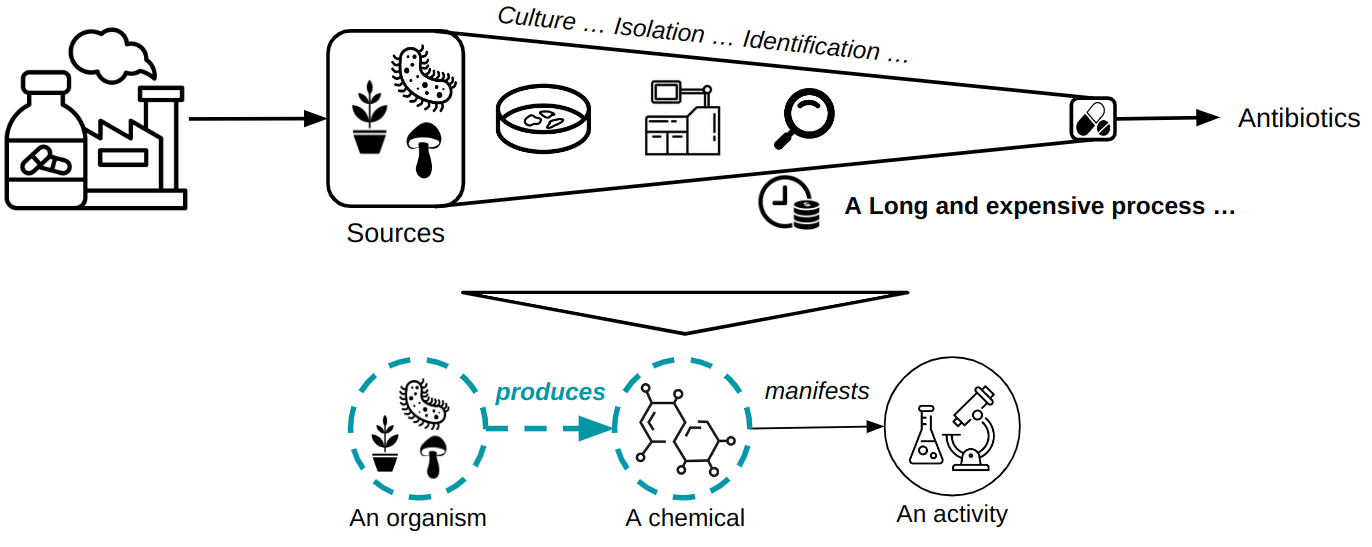

As we have explored previously, extracting relationships from biomedical literature has traditionally focused on well-explored domains, such as chemical–disease or gene-gene associations, where annotated datasets and mature extraction models already exist.

In contrast, less popular areas like the literature on natural products (NPs) remain underexplored despite their importance: NPs are diverse chemical compounds produced by organisms that hold vast therapeutic potential. However, the scarcity of labeled data, the morphological complexity of bio-entities (e.g., long systematic metabolite names, discontinuous enumerations), and the absence of dedicated relation extraction datasets make this domain particularly challenging.

In this context, we are going to explore how large language models (LLMs), with their ability to perform zero- or few-shot learning, can be prompted effectively to identify and extract structured “organism–compound” relations from NP literature.

Also, rather than simply using them as "extractor" we are also going to show are they cna be used as efficient synthetic data generator.

We are going to show some trivial example and then demonstrate the inference of a model, only trained on synthetic data.


* * *

<style>body {text-align: justify}</style>

Here is our first working example: [PMID 24048364](https://pubmed.ncbi.nlm.nih.gov/24048364/)

**Title: Producers and important dietary sources of ochratoxin A and citrinin**

**Abstract:**
<font color='green'>Ochratoxin A</font> (OTA) is a very important mycotoxin, and its research is focused right now on the new findings of OTA, like being a complete carcinogen, information about OTA producers and new exposure sources of OTA. <font color='green'>Citrinin</font> (CIT) is another important mycotoxin, too, and its research turns towards nephrotoxicity. Both additive and synergistic effects have been described in combination with OTA. OTA is produced in foodstuffs by Aspergillus Section Circumdati (<font color='blue'>Aspergillus ochraceus</font>, <font color='blue'>A. westerdijkiae</font>, <font color='blue'>A. steynii</font>) and Aspergillus Section Nigri (<font color='blue'>Aspergillus carbonarius</font>, <font color='blue'>A. foetidus</font>, <font color='blue'>A. lacticoffeatus</font>, <font color='blue'>A. niger</font>, <font color='blue'>A. sclerotioniger</font>, <font color='blue'>A. tubingensis</font>), mostly in subtropical and tropical areas. OTA is produced in foodstuffs by <font color='blue'>Penicillium verrucosum</font> and <font color='blue'>P. nordicum</font>, notably in temperate and colder zones. CIT is produced in foodstuffs by Monascus species (<font color='blue'>Monascus purpureus</font>, <font color='blue'>M. ruber</font>) and Penicillium species (<font color='blue'>Penicillium citrinum</font>, <font color='blue'>P. expansum</font>, <font color='blue'>P. radicicola</font>, <font color='blue'>P. verrucosum</font>). OTA was frequently found in foodstuffs of both plant origin (e.g., cereal products, coffee, vegetable, liquorice, raisins, wine) and animal origin (e.g., pork/poultry). CIT was also found in foodstuffs of vegetable origin (e.g., cereals, pomaceous fruits, black olive, roasted nuts, spices), food supplements based on rice fermented with red microfungi Monascus purpureus and in foodstuffs of animal origin (e.g., cheese).

## But first, let's retry Pubtator


In [ ]:
merged_biomedical_entities, merged_biomedical_relations, documents_texts = pubtator.request_and_parse_pubtator(["24048364"])

In [ ]:
display_entities(merged_biomedical_entities)

Entities have been correctly identified !

In [ ]:
display_relations(merged_biomedical_relations)

But, no relations (of course) ...

For prompting the LLM, we are going use a very simple promting strategy as in this example we only consider one type of relation `-[produces]->` between `Organism` and `Chemicals`.


```python
class NPBiomedicalExtraction(dspy.Signature):
    """
    The task is to extract natural-products relationships between organisms and chemicals from the input text.
    Return all the extracted relations where the text report evidence that an organism produces a chemical, in the form of 'organism produces chemical.'
    You will be given some examples of the tasks.
    """

    pubmed_text: str = dspy.InputField(desc="PubMed title and abstract text")
    relations: List[Tuple[str, str]] = dspy.OutputField(desc="The extraction pair (organism, chemical)")
```

```json
NP_PUBMED_EXAMPLES = [
    {
    "pubmed_text": "Dihydroagarofuran alkaloid and triterpenes from Maytenus heterophylla and Maytenus arbutifolia. The antimicrobially active EtOH extracts of Maytenus heterophylla yielded a new dihydroagarofuran alkaloid,1beta-acetoxy-9alpha-benzoyloxy-2beta,6alpha-dinicotinoyloxy-beta-dihydroagarofuran, together with the known compounds beta-amyrin, maytenfolic acid, 3alpha-hydroxy-2-oxofriedelane-20alpha-carboxylic acid, lup-20(29)-ene-1beta,3beta-diol, (-)-4'-methylepigallocatechin, and (-)-epicatechin. In addition, beta-amyrin, (-)-epicatechin and (-)-4'-methylepigallocatechin were isolated from Maytenus arbutifolia. The structure elucidation of the isolated compounds was based primarily on 1D and 2D NMR analyses, including HMQC, HMBC, and NOESY correlations. Maytenfolic acid showed moderate antimicrobial activity by inhibiting the growth of Candida albicans, Cryptococcus neoformans, Staphylococcus aureus and Pseudomonas aeruginosa.",
    "relations": [
        ("Maytenus heterophylla", "1beta-acetoxy-9alpha-benzoyloxy-2beta,6alpha-dinicotinoyloxy-beta-dihydroagarofuran"),
        ("Maytenus heterophylla", "beta-amyrin"),
        ("Maytenus heterophylla", "maytenfolic acid"),
        ("Maytenus heterophylla", "3alpha-hydroxy-2-oxofriedelane-20alpha-carboxylic acid"),
        ("Maytenus heterophylla", "lup-20(29)-ene-1beta,3beta-diol"),
        ("Maytenus heterophylla", "(-)-4'-methylepigallocatechin"),
        ("Maytenus heterophylla", "(-)-epicatechin"),
      ]
    },
    {
    "pubmed_text": "Gloeophyllins A-J, Cytotoxic Ergosteroids with Various Skeletons from a Chinese Tibet Fungus Gloeophyllum abietinum. Ten new ergosteroids, gloeophyllins A-J (1-10), have been isolated from the solid cultures of Gloeophyllum abietinum. The absolute configurations of 1, 2, and 9 were determined by X-ray crystallographic analysis. Compound 1 has a rare C-nor-D-homosteroid skeleton. Compound 9 possesses an unusual ergostane skeleton having a 10-oxabicyclo [4.3.1] decane moiety replacing 6/5 fused C/D rings. Compound 10 represents the first ergosteroid featuring the cleavage of a C8-C14 bond. The cytotoxicity of 1-10 was tested against the human cancer cell lines K562 and HCT116. The biosynthetic pathway for 1-10 is postulated.",
    "relations": [
          ("Gloeophyllum abietinum", "gloeophyllin A"),
          ("Gloeophyllum abietinum", "gloeophyllin B"),
          ("Gloeophyllum abietinum", "gloeophyllin C"),
          ("Gloeophyllum abietinum", "gloeophyllin D"),
          ("Gloeophyllum abietinum", "gloeophyllin E"),
          ("Gloeophyllum abietinum", "gloeophyllin F"),
          ("Gloeophyllum abietinum", "gloeophyllin G"),
          ("Gloeophyllum abietinum", "gloeophyllin H"),
          ("Gloeophyllum abietinum", "gloeophyllin I"),
          ("Gloeophyllum abietinum", "gloeophyllin J"),
      ]
    },
    {
        "pubmed_text": "New cyclic peptides from the ascidian Lissoclinum patella. Four new cyclic peptides, patellamide G (2) and ulithiacyclamides E-G (3-5), along with the known patellamides A-C (6-8) and ulithiacyclamide B (9), were isolated from the ascidian Lissoclinum patella collected in Pohnpei, Federated States of Micronesia. The planar structures of these peptides were determined from 1D and 2D 1H and 13C NMR spectra. The absolute stereochemistries of the amino acid units, except for cysteine, were assigned by chiral GC analysis of N(O)-trifluoroacetyl isopropyl ester derivatives of amino acids obtained by acid hydrolysis of the intact and ozonized peptides. The structures of ulithiacyclamides E-G (3-5) were confirmed by chemical conversion. Patellamides B (7) and C (8) exhibited in vitro modulation of multidrug resistance in CEM/VBL100 cells.",
        "relations": [
            ("Lissoclinum patella", "patellamide G"),
            ("Lissoclinum patella", "ulithiacyclamide E"),
            ("Lissoclinum patella", "ulithiacyclamide F"),
            ("Lissoclinum patella", "ulithiacyclamide G"),
            ("Lissoclinum patella", "patellamide A"),
            ("Lissoclinum patella", "patellamide B"),
            ("Lissoclinum patella", "patellamide C"),
            ("Lissoclinum patella", "ulithiacyclamide B"),
        ],
    },
]
```

In [ ]:
np_extractor_llama = BiomedicalExtractor(
    prompt=NPBiomedicalExtraction,
    llm_type="ollama",
    model="ollama_chat/vicuna:13b",    # ollama_chat/vicuna:13b
    base_url="http://127.0.0.1:11434"
)

pubmed_text = """
Producers and important dietary sources of ochratoxin A and citrinin.
Ochratoxin A (OTA) is a very important mycotoxin, and its research is focused right now on the new findings of OTA, like being a complete carcinogen, information about OTA producers and new exposure sources of OTA. Citrinin (CIT) is another important mycotoxin, too, and its research turns towards nephrotoxicity. Both additive and synergistic effects have been described in combination with OTA. OTA is produced in foodstuffs by Aspergillus Section Circumdati (Aspergillus ochraceus, A. westerdijkiae, A. steynii) and Aspergillus Section Nigri (Aspergillus carbonarius, A. foetidus, A. lacticoffeatus, A. niger, A. sclerotioniger, A. tubingensis), mostly in subtropical and tropical areas. OTA is produced in foodstuffs by Penicillium verrucosum and P. nordicum, notably in temperate and colder zones. CIT is produced in foodstuffs by Monascus species (Monascus purpureus, M. ruber) and Penicillium species (Penicillium citrinum, P. expansum, P. radicicola, P. verrucosum). OTA was frequently found in foodstuffs of both plant origin (e.g., cereal products, coffee, vegetable, liquorice, raisins, wine) and animal origin (e.g., pork/poultry). CIT was also found in foodstuffs of vegetable origin (e.g., cereals, pomaceous fruits, black olive, roasted nuts, spices), food supplements based on rice fermented with red microfungi Monascus purpureus and in foodstuffs of animal origin (e.g., cheese).
"""

result = np_extractor_llama.extract(pubmed_text, demonstrations=NP_PUBMED_EXAMPLES)


In [ ]:
dspy.inspect_history(1)

not bad, but we miss a lot of relations !!

In [ ]:
np_extractor_openai = BiomedicalExtractor(
    prompt=NPBiomedicalExtraction,
    llm_type="openai",
    model="gpt-4o-mini"
)

result_openai = np_extractor_openai.extract(pubmed_text, demonstrations=NP_PUBMED_EXAMPLES)

In [ ]:
dspy.inspect_history(1)

For this toy example, no problem for GPT-4 ! However, this strategy will not scale if we have to apply to large set of documents or more complex examples (or private data). And also, do we need > 50B parameters for this task ?


So here comes the question: how can we **distill** the few-shots abilities of LLM to train smaller models ?
The answer: Synthetic Data Generation



# 3. Synthetic Data Generation

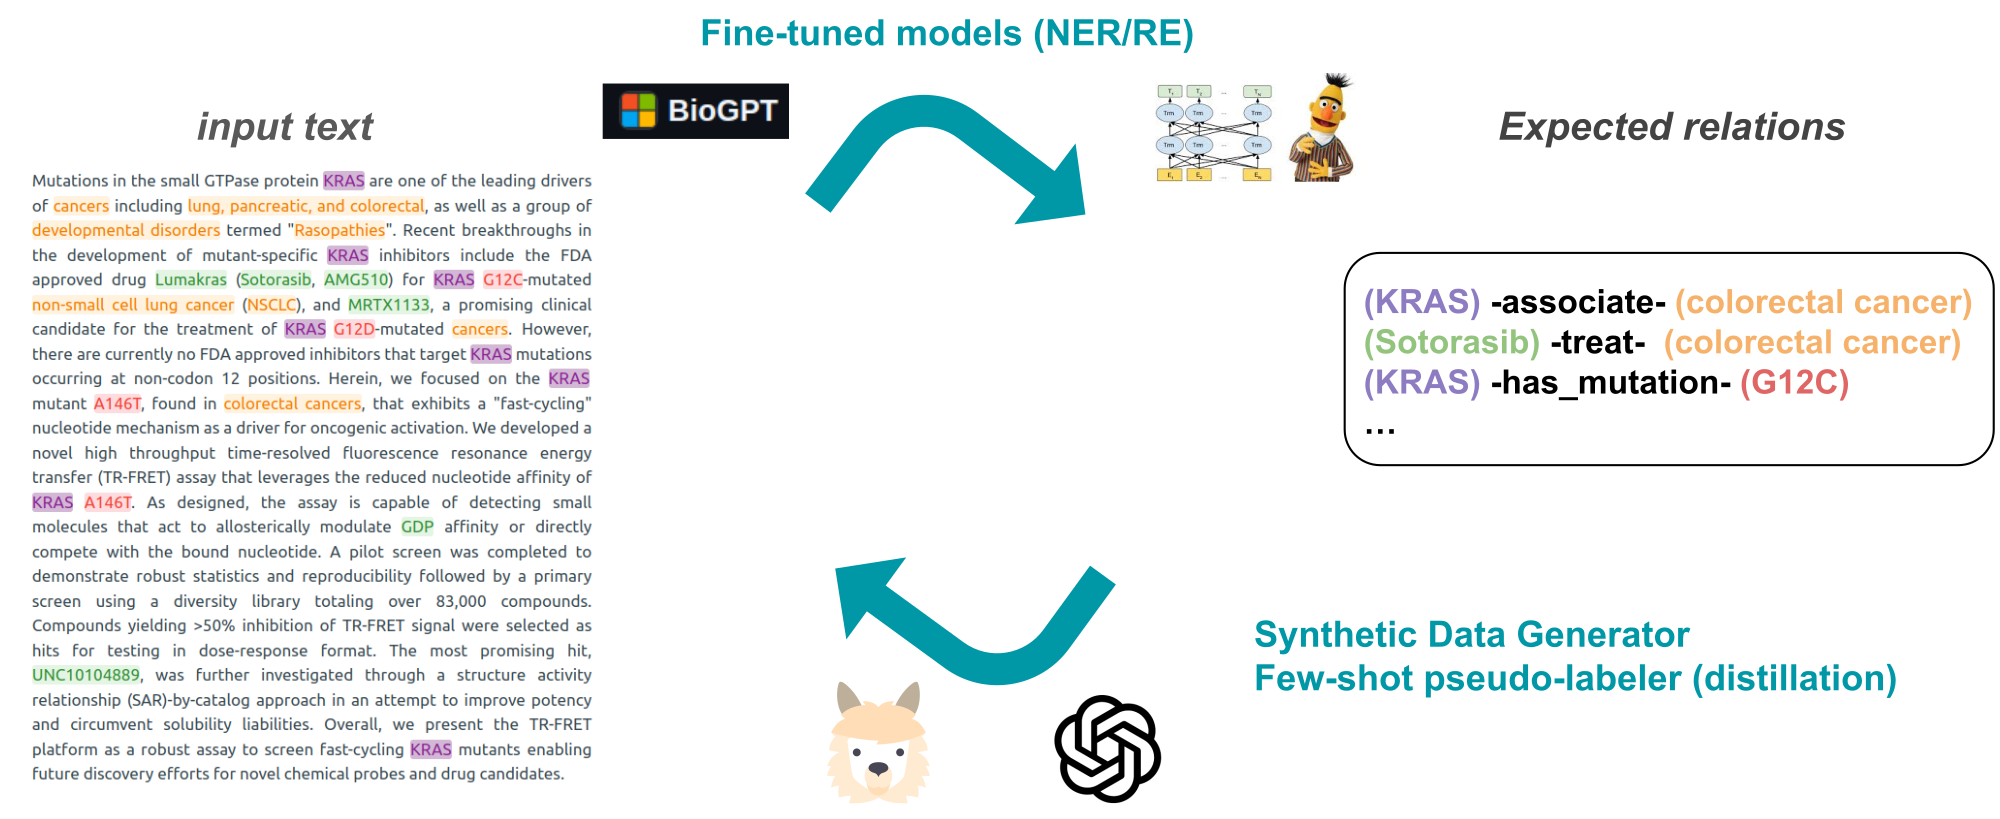

## Simple prompting to generate synthetic data



Maybe `vicuna:13b` is too small to perform the task as well as GPT-4 in few-shots. However what happens if we ask him the opposite ? Generat me some abstracts given some instructions that I can control.

For instance:

**Instructions:** Given a title, a list of keywords and main findings, create an abstract for a scientific article.

**Title:** Cucurbitane glycosides from the fruits of Siraitia gros venorii and their inhibitory effects on Epstein-Barr virus activation.

**Keywords:** epstein-barr virus, inhibitory effects.

**Main findings:** 11-Oxomogroside IV A (1), Mogroside II B (2), 7-Oxomogroside II-E (3) and 7-Oxomogroside V (4) were isolated from Siraitia grosvenorii. Mogroside IIe (5), Isomogroside-V (6) and mogroside III A2 (7) were isolated from Siraitia. Vitamin P (8) were isolated from Cucurbita moschata.

**Abstract**: [to generate]



We can also play a bit with the temperature !

* * *

An other strategy would be to generate pseudo-labels directly from abstracts, however it offer us less control.

In [112]:
prompt_1 = "Instructions: Given a title, a list of keywords and main findings, create an abstract for a scientific article.\nTitle: Anti-inflammatory compounds from Sideritis javalambrensis n-hexane extract.\nKeywords: carrageenan mouse paw edema test, anti-inflammatory activities, active principles, purified fractions, esters of tyrosol with fatty acids.\nMain findings: Tyrosyl stearate, OH-Manoyl oxide, Tyrosyl palmitate, [(2S)-2-amino-3-(4-hydroxyphenyl)propanoyl] docosanoate and [(2S)-2-amino-3-(4-hydroxyphenyl)propanoyl] tetracosanoate were isolated from Sideritis javalambrensis. OH-Manoyl oxide, [(2S)-2-amino-3-(4-hydroxyphenyl)propanoyl] docosanoate, [(2S)-2-amino-3-(4-hydroxyphenyl)propanoyl] tetracosanoate, Tyrosyl stearate and Tyrosyl palmitate were isolated from Sideritis pungens. Tyrosyl stearate, [(2S)-2-amino-3-(4-hydroxyphenyl)propanoyl] docosanoate, OH-Manoyl oxide, [(2S)-2-amino-3-(4-hydroxyphenyl)propanoyl] tetracosanoate and Tyrosyl palmitate were isolated from Sideritis linearifolia.\nAbstract"
prompt_2 = "Instructions: Given a title, a list of keywords and main findings, create an abstract for a scientific article.\nTitle: Cucurbitane glycosides from the fruits of Siraitia gros venorii and their inhibitory effects on Epstein-Barr virus activation.\nKeywords: epstein-barr virus, inhibitory effects.\nMain findings: 11-Oxomogroside IV A (1), Mogroside II B (2), 7-Oxomogroside II-E (3) and 7-Oxomogroside V (4) were isolated from Siraitia grosvenorii. Mogroside IIe (5), Isomogroside-V (6) and mogroside III A2 (7) were isolated from Siraitia. Vitamin P (8) were isolated from Cucurbita moschata.\nAbstract:"
prompt_3 = "Instructions: Given a title, a list of keywords and main findings, create an abstract for a scientific article.\nTitle: Chemical constituents of Equisetum debile.\nKeywords: chemical methods, spectral methods, chemical constituents, isolation, whole plant, structures, structure elucidation, compound, structural elucidation.\nMain findings: Ferulic acid, Lariciresinol 9-O-|A-D-glucopyranoside, 4-Hydroxycinnamic acid and Thymidine were isolated from Equisetum ramosissimum. (2R,4S)-6-(3-hydroxy-4-methoxyphenyl)hexane-1,2,4-triol, 3-(4-Hydroxy-3-methoxyphenyl)prop-2-enoic acid, L-Thymidine, 2-Propenoic acid, 3-(4-hydroxyphenyl)-, (2Z)-, 4-Oxoniobenzoate, erythro-Guaiacylglycerol beta-coniferyl ether, 5-Hydroxymethylfurfural and (2S)-2-pentyl-1,5,9-triazacyclotridecan-4-one were isolated from Equisetum debile. 4-Hydroxycinnamic acid, Ferulic acid, Thymidine and Lariciresinol 9-O-|A-D-glucopyranoside were isolated from Equisetum giganteum.\nAbstract:"

In [ ]:
print(prompt_2)

In [108]:
prompt_KRAS = """
Instructions: Given a title, a list of keywords and main findings, create an abstract for a scientific article.

Title: Targeting KRAS Variants in Cancer: Molecular Associations and Emerging Therapeutic Inhibitors

Keywords: KRAS mutations, Non-small cell lung cancer (NSCLC), Colorectal cancer, Variant–disease associations, Small-molecule inhibitors, Structure-based drug design, Preclinical validation, Biomarker-driven therapies, Clinical trials, Precision oncology

Main findings: KRAS (gene) cause cancers; Variant KRAS G12C associated wth non-small cell lung cancer; Lumakras (chemical) inhibits Variant KRAS G12C; Lumakras (chemical) treatnon-small cell lung cancer MRTX1133 (Chemical) inhibits Variant KRAS G12D Variant;  KRAS A146T (Variant) associated with colorectal cancers; UNC10104889 (Chemical) inhibits KRAS A146T (Variant)

Abstract:
"""

In [ ]:
# select a prompt
prompt = prompt_2

print(f"What we send to the model: \n{prompt}")
from openai import OpenAI
client = OpenAI(
    api_key="FREE",
    base_url="http://127.0.0.1:11434/v1",
)

response = client.chat.completions.create(
    model="vicuna:13b",
    messages=[
            {"role": "system", "content": "You are un expert in synthetic abstract generation."},
            {"role": "user", "content": prompt},
        ],
    temperature=0.7
)

output = response.choices[0].message.content

In [ ]:
display(Markdown(output))

Then I actually have create my data:

**Input**: [Synthetic abstracts]

**Output**: [list of relation I inputed while creating the abstract]


We can generate like this many *synthetic* abstracts for which we control the expected labels.
The relations that we pass do not need to be factuals, but the additional description we put also help to improve the diversity of the generated examples.


## Pseudo-labeler

Alternatively LLM could also be used a pseudo-labelers. Indeed for task like NER, encoder models can reach correct performances with a thousands of examples. An other strategy is then to use LLM to create pseudo-labels. Then we fine-tune models on this pseudo-labels. This process is called *distillation*. However the performance of our fine-tuned (the *student*) models are naturally bounded by the performance of the used LLM (the *teacher*)

## Inference over a BioGPT model trained on synthetic data

On this [Zenodo repository](https://zenodo.org/records/8422294) you can find all the synthetic abstracts that we have generated.

After this, we simply trained a BioGPT model for end-to-end NER and RE on this synthetic abstracts.

Below are the fine-tuned models.

In [ ]:
import gc
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

In [ ]:
# We only have a small GPU so be sure ollama is down.
! pgrep ollama

In [ ]:
! kill 38879

In [ ]:
# model and adapters path
model_hf = "microsoft/BioGPT-Large"
lora_adapters = "mdelmas/BioGPT-Large-Natural-Products-RE-Diversity-synt-v1.0" # You can also try: mdelmas/BioGPT-Large-Natural-Products-RE-Extended-synt-v1.0

# Load model and plug adapters using peft
model = AutoModelForCausalLM.from_pretrained(model_hf, device_map={"":0})
model = PeftModel.from_pretrained(model, lora_adapters)
model = model.merge_and_unload()
tokenizer = AutoTokenizer.from_pretrained(model_hf)

In [ ]:
def inference(text):
    device = torch.device("cuda")

    # Decoding arguments
    EVAL_GENERATION_ARGS = {"max_length": 1024,
                            "do_sample": False,
                            "forced_eos_token_id": tokenizer.eos_token_id,
                            "num_beams": 3,
                            "early_stopping": True,
                            "length_penalty": 1.5,
                            # "temperature": 0
                            }

    # Prepare the input
    input_text = text + tokenizer.eos_token + tokenizer.bos_token

    # Tokenize
    input_tokens = tokenizer(input_text, return_tensors='pt')
    input_tokens.to(device)

    # Generate
    with torch.no_grad():
      beam_output = model.generate(**input_tokens, **EVAL_GENERATION_ARGS)
    output = tokenizer.decode(beam_output[0][len(input_tokens["input_ids"][0]):], skip_special_tokens=True)

    # Parse and print
    rels = output.strip().split("; ")
    for rel in rels:
      print("- " + rel)
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
title_text = "Producers and important dietary sources of ochratoxin A and citrinin."
abstract_text = "Ochratoxin A (OTA) is a very important mycotoxin, and its research is focused right now on the new findings of OTA, like being a complete carcinogen, information about OTA producers and new exposure sources of OTA. Citrinin (CIT) is another important mycotoxin, too, and its research turns towards nephrotoxicity. Both additive and synergistic effects have been described in combination with OTA. OTA is produced in foodstuffs by Aspergillus Section Circumdati (Aspergillus ochraceus, A. westerdijkiae, A. steynii) and Aspergillus Section Nigri (Aspergillus carbonarius, A. foetidus, A. lacticoffeatus, A. niger, A. sclerotioniger, A. tubingensis), mostly in subtropical and tropical areas. OTA is produced in foodstuffs by Penicillium verrucosum and P. nordicum, notably in temperate and colder zones. CIT is produced in foodstuffs by Monascus species (Monascus purpureus, M. ruber) and Penicillium species (Penicillium citrinum, P. expansum, P. radicicola, P. verrucosum). OTA was frequently found in foodstuffs of both plant origin (e.g., cereal products, coffee, vegetable, liquorice, raisins, wine) and animal origin (e.g., pork/poultry). CIT was also found in foodstuffs of vegetable origin (e.g., cereals, pomaceous fruits, black olive, roasted nuts, spices), food supplements based on rice fermented with red microfungi Monascus purpureus and in foodstuffs of animal origin (e.g., cheese)."
text = title_text + " " + abstract_text
inference(text)

In [ ]:
model = None
torch.cuda.empty_cache()

# 4. Large scale extraction and Neo4J

We are going to build a first larger KG. For this example we will be considering a subset of the [bioasq](https://participants-area.bioasq.org/datasets) validation set. The subset of PMID we are using is in the file `sampled_documents_pmids.json`.

The BioASQ challenge datasets are built around biomedical question answering. Typically, each question comes with a list of PubMed identifiers from which the answer (or some part of it) can be found in the document.

They use four main question types:

**- Yes/No questions:**

Require a binary answer (yes or no).

Example: “Is aspirin an anti-inflammatory drug?”

**- Factoid questions:**

Expect a short, specific answer (entity or phrase).

Example: “What is the gene symbol for tumor protein p53?” → “TP53”

**- List questions:**

Expect a list of items as the answer.

Example: “Which drugs are used for the treatment of hypertension?”

- **Summary questions:**

Require a short, well-formed text summary, synthesizing information from multiple documents/snippets.

Example: “What are the common side effects of statins?”


* * *

Using these questions, we are going to experiment in the next notebook with some RAG strategies.

But first, let's use PubTator, to quicky get a graph and visualise it with Neo4J.




## Use ou PubTator Client

Here are going to load the json of PMIDs and then request PubTator for the relations. From this we are going to load them into Neo4J.


**What is Neo4J ?**
Neo4j is a popular graph database designed to store and query highly connected data.

Neo4j uses a declarative query language called Cypher, which is optimized for expressing graph patterns in an intuitive way. For example, you can write a query to find all drugs that treat by a given disease using a simple path-matching syntax.

Because of its graph-native storage and traversal engine, Neo4j can handle deep relationship queries efficiently—tasks.

However, this is not intended as a Neo4j tutorial; we use it here simply because it is clear, illustrative, and easy to set up for demonstrating our approach.

In [116]:
pubtator = PubTatorClient(base_url="https://www.ncbi.nlm.nih.gov/research/pubtator3-api/publications/export/biocjson")

In [ ]:
with open("/content/sampled_documents_pmids.json", "r") as f:
    all_pmids = json.load(f)

display(f"There are {len(all_pmids)} pubmed documents.")

In [ ]:
merged_biomedical_entities, merged_biomedical_relations, documents_texts = pubtator.request_and_parse_pubtator(all_pmids)

In [120]:
# Save to json
import json
with open("merged_biomedical_entities.json", "w") as f:
    json.dump(merged_biomedical_entities, f, indent=4)

with open("merged_biomedical_relations.json", "w") as f:
    json.dump(merged_biomedical_relations, f, indent=4)

with open("documents_texts.json", "w") as f:
    json.dump(documents_texts, f,indent=4)

## Loading and connecting to Neo4J Aura



For the demonstration in this tutorial, we are going to use [**Neo4J aura**](https://neo4j.com/product/auradb/).

Neo4j Aura is the fully managed, cloud-based offering of Neo4j. Instead of installing and maintaining the graph database yourself, Aura lets you spin up a Neo4j instance in seconds on the cloud, with automatic scaling, backups, security, and monitoring handled for you. (and it is free !)

In [ ]:
# Standard setup for participants
!pip install neo4j pandas matplotlib seaborn

In [122]:
import pandas as pd
from tqdm import tqdm
from neo4j import GraphDatabase

In [123]:
# =============================================================================
# 1. CONNECTION SETUP
# =============================================================================
# Replace with your Neo4j Aura credentials
NEO4J_URI = "neo4j+s://1c51a1ef.databases.neo4j.io"  # Note: neo4j+s for Aura
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "LwJT5kjrM1dX5ntarTB0XRY8LCrfBqoOA0_IRjRLGOg"

In [124]:
# =============================================================================
# HERE IS A SHORT EXAMPLE OF DATA
# (Again this is not a Neo4J toturial)
# So (nodes) simply have 2 'properties' a 'name' and an 'id'
# -[relationships]-> are only caracterized by their relation type
# =============================================================================

import os
import json
import pandas as pd

with open("/content/merged_biomedical_entities.json", "r") as f:
    nodes_data = pd.DataFrame(json.load(f))

with open("/content/merged_biomedical_relations.json", "r") as f:
    relationships_data = pd.DataFrame(json.load(f))

In [ ]:
print("Nodes Data Sample:")
display(nodes_data[:5]) # Display the first 5 nodes

print("\nRelationships Data Sample:")
display(relationships_data[:5]) # Display the first 5 relationships

In [126]:
class Neo4jLoader:
  def __init__(self, uri, user, password):
    self.driver = GraphDatabase.driver(uri, auth=(user, password))
    self.test_connection()

  def test_connection(self):
    """
    Just a simple test for the connection
    """
    with self.driver.session() as session:
        result = session.run("RETURN 'Connection successful!' as message")
        return result.single()["message"]

  def close(self):
    """
    Close the driver connection
    """
    self.driver.close()

  def clear_data(self):
    """
    Delete all nodes and relationships in the database
    """
    with self.driver.session() as session:
      session.run('MATCH (n) DETACH DELETE n')

  def add_constraints(self, labels):
      """
      Add unique constraints for any list of labels

      Args:
          labels: List of node labels (e.g., ['Drug', 'Disease', 'Gene'])
      """
      with self.driver.session() as session:
          for label in labels:
              # Create constraint name (lowercase + _id_unique)
              constraint_name = f"{label.lower()}_id_unique"

              constraint_query = f"""
              CREATE CONSTRAINT {constraint_name} IF NOT EXISTS
              FOR (n:{label}) REQUIRE n.id IS UNIQUE
              """

              try:
                  session.run(constraint_query)
                  print(f"✅ Created constraint for {label}")
              except Exception as e:
                  print(f"⚠️ Constraint for {label} already exists or error: {str(e)[:50]}")

  def insert_nodes(self, node_data, batch_size=1000):
      """
      Insert nodes from standardized DataFrame - fully flexible for any labels

      Args:
          node_data: DataFrame with columns ['label', 'id', 'name']
          batch_size: Records per batch
      """
      total_created = 0

      # Fist, add the constrains:
      self.add_constraints(node_data['label'].unique().tolist())

      with self.driver.session() as session:
          # Group by label and process each type
          for label in node_data['label'].unique():
              label_data = node_data[node_data['label'] == label].to_dict('records')

              # Dynamic query for any label
              query = f"""
              UNWIND $batch AS row
              MERGE (n:{label} {{id: row.id}})
              SET n.name = row.name,
                  n.pmids = row.pmids,
                  n.alt_names = row.alt_names
              RETURN count(n) as created
              """

              # Process in batches
              for i in range(0, len(label_data), batch_size):
                  batch = label_data[i:i + batch_size]
                  session.run(query, batch=batch)
                  total_created += len(batch)

      print(f"✅ Inserted {total_created} nodes")

  def insert_relationships(self, relationships_data, batch_size=1000):
      """
      Insert relationships from standardized DataFrame - fully flexible for any labels/relationships

      Args:
          relationships_data: DataFrame with columns ['source_id', 'source_label', 'target_id', 'target_label', 'relationship']
          batch_size: Records per batch
      """
      total_created = 0

      with self.driver.session() as session:
          # Group by unique combination of source_label, target_label, and relationship type
          grouped = relationships_data.groupby(['source_label', 'target_label', 'relationship'])

          for (source_label, target_label, rel_type), group in grouped:
              group_data = group.to_dict('records')

              # Dynamic query for any labels and relationship types
              query = f"""
              UNWIND $batch AS row
              MATCH (source:{source_label} {{id: row.source_id}})
              MATCH (target:{target_label} {{id: row.target_id}})
              MERGE (source)-[r:{rel_type}]->(target)
              SET r.pmids = row.pmids
              RETURN count(r) as created
              """

              # Process in batches
              for i in range(0, len(group_data), batch_size):
                  batch = group_data[i:i + batch_size]
                  session.run(query, batch=batch)
                  total_created += len(batch)

      print(f"✅ Inserted {total_created} relationships")



In [127]:
loader = Neo4jLoader(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)

In [128]:
loader.clear_data()

In [ ]:
loader.insert_nodes(nodes_data)
loader.insert_relationships(relationships_data)

let's try this query first:
```cypher
// Get 100 random nodes with their relationships
MATCH (n)
WITH n LIMIT 100
OPTIONAL MATCH (n)-[r]-(m)
RETURN n, r, m
```

# 5. Entity Linking

Entity linking is already performed by PubTator so our graph is already connecting desambiguated nodes. However, if you are curious on the typical protocol that is applied for entity linking, please, check our notebook `Entity Linking`.

# More on the comparison

[*Thinking about GPT-3 In-Context Learning for Biomedical IE? Think Again*](https://doi.org/10.18653/v1/2022.findings-emnlp.329)

[*Improving large language models for clinical named entity recognition via prompt engineering*](https://doi.org/10.1093/jamia/ocad259)

[*Advancing entity recognition in biomedicine via instruction tuning of large language models*](https://doi.org/10.1093/bioinformatics/btae163)

[*LLMs in Biomedicine: A study on clinical Named Entity Recognition*](https://doi.org/10.48550/arXiv.2404.07376)

[*Do LLMs Surpass Encoders for Biomedical NER?*](https://doi.org/10.48550/arXiv.2504.00664)

[*On-the-fly Definition Augmentation of LLMs for Biomedical NER*](https://doi.org/10.18653/v1/2024.naacl-long.212)

[*LLMs are not Zero-Shot Reasoners for Biomedical Information Extraction*](https://doi.org/10.18653/v1/2025.insights-1.11)